In [3]:
#NETREX
#needed for package

import numpy as np
import pandas as pd
import sys
from implicit import als
import math
import cvxopt
from scipy.linalg import fractional_matrix_power, block_diag
import matplotlib
from pylab import *
import argparse
import mosek
from scipy.sparse import csr_matrix
import copy
from cvxpy import *


#testing
import warnings
#netrex

class NetREX: 
    #init
    def __init__(self, E, C, lambda_, theta=1, alpha=10, iternum = 300, p = 30, solver = ECOS):
        #parameters
        self.theta = theta # scalar > 0
        self.alpha = alpha
        self.xbound = 1.0
        self.ybound = 1.0
        self.iternum = iternum
        self.lambda_ = lambda_ #parameter matrix
        #read in exp, read prior data 
        #self.ReadExp(ExpFile) #get ExpMat from this
        self.ExpMat = E #expression for now
        self.C = C #matrix of confidences (weights)
        self.NumGene = E.shape[0]
        self.NumTF = C.shape[1]
        self.NumExp = E.shape[1]
        #parameter matrix eta
        self.eta = self.C + theta
        self.i_ = range(self.NumGene) #range of i
        self.j_ = range(self.NumTF) #range of j 
        #controls amount of factors in xi/yj
        self.p = p
        #set solver
        self.solver = solver
        
    #Put read in exp here later
    
    #initialization
    def initialization(self):
        #!!! other parameters!!!
        #Use implicit package for CF problems to initialize X & Y: 
        implicit_model = als.AlternatingLeastSquares(factors=self.p)
        #add to get new weight matrix
        C_adj = 1 + 40*self.C
    
        
        #train model on weight matrix
        #implicit_model.fit(csr_matrix(C_cutoff))
        implicit_model.fit(csr_matrix(C_adj))
        #initial X (matrix of xi vectors)
        self.X = implicit_model.item_factors.T
        for i in self.i_:
            TmpNorm = np.linalg.norm(self.X[:,i])
            if TmpNorm < 1E-5:
                continue
            self.X[:,i] = self.X[:,i] / TmpNorm
        np.nan_to_num(self.X, copy=False)
        #initial Y (matrix of yj vectors)
        self.Y = implicit_model.user_factors.T
        for j in self.j_:
            TmpNorm = np.linalg.norm(self.Y[:,j])
            if TmpNorm < 1E-5:
                continue
            self.Y[:,j] = self.Y[:,j] / TmpNorm
        np.nan_to_num(self.Y, copy=False)
        
        #set initial S to C
        #self.S = copy.deepcopy(self.C)
        #binarize S to use for finding A 
        #S_init = (self.S > 0).astype(int)
        #initialize A using NetREX 1 closed form
        #!!!!!Other options!!!!!
        #Abound = 1.0
        #self.A = np.linalg.inv(S_init.T.dot(S_init)+np.eye(self.NumTF)).dot(S_init.T).dot(self.ExpMat)
        #self.A = np.multiply((np.absolute(Atmp)<=Abound), Atmp) + \
                                       # np.multiply((np.absolute(Atmp)>Abound), np.sign(Atmp)*Abound)
        
        #try using NCA to get initial A
        self.A = self.NCA_()
        
        #initial Uk
        mu_S = np.linalg.norm(self.A.dot(self.A.T), 'fro')
        Uk = self.S - (2./mu_S)*(self.S.dot(self.A).dot(self.A.T) - self.ExpMat.dot(self.A.T))
        #initial S 
        c = np.sqrt((2./mu_S)*(self.alpha*self.lambda_*np.square(np.ones([self.NumGene,self.NumTF]) -
                                                          self.X.T.dot(self.Y)) + self.eta))  
        Sequal = np.where(np.absolute(Uk) == c, c*np.random.randint(2, size=(self.NumGene,self.NumTF)), 0)
        Sgreater = np.where(np.absolute(Uk) > c, Uk, 0)
        self.S = Sequal + Sgreater
        
        plt.figure(1, figsize=(8, 8))
        ax1 = plt.subplot(211)
        ax1.imshow(self.S)
        ax2 = plt.subplot(212)
        ax2.imshow(self.X.T.dot(self.Y))
        plt.show() 
    
    #try to program iterative NCA
    def NCA_(self):
        #set initial S to C
        self.S = copy.deepcopy(self.C)
        #binarize S to use for finding A 
        S_init = (self.S > 0).astype(int).astype(float)
        for k in range(50):
            A_init = np.linalg.inv(S_init.T.dot(S_init)+ 0.1*np.eye(self.NumTF)).dot(S_init.T).dot(self.ExpMat)
            # update S
            for i in range(self.NumGene):
                Indn0 = np.where(self.S[i,:]!=0)[0]
                Et = self.ExpMat[i,:]
                At = A_init[Indn0,:]
                St = Et.dot(At.T).dot(np.linalg.inv(At.dot(At.T)+0.1*np.eye(At.shape[0])))
                S_init[i,Indn0] = St 
            
        return A_init
        
    #Define the objective function 
    def ObjFunction(self):
        S_0 = (self.S != 0).astype(int) 
        self.a_ = self.lambda_*(self.C + self.alpha*S_0)
        W = np.sqrt(self.a_) 
        Val = np.linalg.norm(self.ExpMat - self.S.dot(self.A), 'fro')**2 +np.linalg.norm(W*(S_0 - self.X.T.dot(self.Y)),
                    'fro')**2 + np.linalg.norm(np.sqrt(self.eta*S_0), 'fro')**2
        return Val
    
    def PALM_A(self):
        mu_A = np.linalg.norm(self.S.T.dot(self.S), 'fro')
        #solution for A
        self.A = (np.linalg.inv((2./mu_A)*self.S.T.dot(self.S)+ np.identity(self.NumTF))).dot(((2./mu_A) * 
                                                                self.ExpMat.T.dot(self.S) + self.A.T).T) 
        
    def PALM_S(self):
        mu_S = np.linalg.norm(self.A.dot(self.A.T), 'fro')
        Uk = self.S - (2./mu_S)*(self.S.dot(self.A).dot(self.A.T) - self.ExpMat.dot(self.A.T))
        c = np.sqrt((2./mu_S)*(self.alpha*self.lambda_*np.square(np.ones([self.NumGene,self.NumTF]) -
                                                          self.X.T.dot(self.Y)) + self.eta))
        '''
        plt.figure(1, figsize=(8, 3))
        ax1 = plt.subplot(211)
        ax1.imshow(c)
        ax2 = plt.subplot(212)
        ax2.imshow(Uk)
        plt.show() 
        
        print(c[30:, 0:20])
        print(Uk[30:, 0:20])
        '''
        
        #solution for S   
        Sequal = np.where(np.absolute(Uk) == c, c*np.random.randint(2, size=(self.NumGene,self.NumTF)), 0)
        Sgreater = np.where(np.absolute(Uk) > c, Uk, 0)
        self.S = Sequal + Sgreater
        #print(self.S)
        self.S_0 = (self.S != 0).astype(int)
    
    def solve_qcqp(self, phi, varphi): 
        '''
        Use cvxpy to solve the problem: 
        min x^T*phi*x + varphi*x
        s.t. to norm(x) <= 1
        (problem is the same for y)
        '''
        x = Variable(self.p)
        P = (phi/10.).astype(np.double) #this is phi modified for cvxpy
        q = (varphi/10.).astype(np.double) #varphi modified for cvxpy
        
        #print(P, q)
        objective = Minimize(quad_form(x,P) - q.T*x)
        constraints = [square(norm(x)) <= 1]
        
        prob = Problem(objective, constraints)
        
        try:
            result = prob.solve(solver=self.solver)
            return x.value
        except:
            print(P, q)
            prob.solve(verbose=True)
            
            
           
    def PALM_x(self):
        #define variables for matrix formulation
        for i in self.i_: 
            x = self.X[:,i]
            S_0 = (self.S != 0).astype(int)
            a_ = self.lambda_*(self.C + self.alpha*S_0)
            A_i = np.diag([a_[i,j] for j in self.j_])
            S_i = np.array([S_0[i,j] for j in self.j_]) 
            mu_x = np.linalg.norm(2*self.Y.dot(A_i).dot(self.Y.T), 'fro')                            
            phi = (mu_x/2)*np.identity(self.p) + self.Y.dot(A_i).dot(self.Y.T)
            varphi = 2*S_i.dot(A_i).dot(self.Y.T) + mu_x*x.T 
            self.X[:,i] = self.solve_qcqp(phi, varphi)
        
    def PALM_y(self):
        #matrix formulation
        for j in self.j_:
            y = self.Y[:,j]
            S_0 = (self.S != 0).astype(int)
            a_ = self.lambda_*(self.C + self.alpha*S_0)
            A_j = np.diag([a_[i,j] for i in self.i_])
            S_j = np.array([S_0[i,j] for i in self.i_])
            mu_y = np.linalg.norm(2*self.X.dot(A_j).dot(self.X.T), 'fro')
            phi = (mu_y/2)*np.identity(self.p) + self.X.dot(A_j).dot(self.X.T)
            varphi = 2*S_j.T.dot(A_j).dot(self.X.T) + mu_y*y.T
            #print(np.ptp(self.X.dot(A_j).dot(self.X.T)))
            #print(np.ptp(phi), np.ptp(varphi))
            #print(j, np.ptp(2*S_j.T.dot(A_j).dot(self.X.T)))
            #print(j, np.amax(y.T), np.amin(y.T))
            #print(j, mu_y)
            self.Y[:,j] = self.solve_qcqp(phi, varphi)
            
    #algorithm
    def NetREX_algorithm(self):
        self.initialization()
        conv_point = 10 #for now?  

        Valold = self.ObjFunction()
        for k in range(self.iternum): 
            self.PALM_A()
            
            '''
            plt.figure(1, figsize=(40, 30))
            ax1 = plt.subplot(211)
            ax1.imshow(self.A)
            plt.show()
            
            plt.figure(1, figsize=(40, 30))
            ax1 = plt.subplot(211)
            n, bins, patches = plt.hist(self.A.flatten(), 50, density=True, facecolor='g', alpha=0.75)
            plt.show()
            
            
            print(np.amin(self.A))
            '''
            
            self.PALM_S()
            self.PALM_x()
            self.PALM_y()
            
            '''plt.figure(1, figsize=(40, 30))
            ax1 = plt.subplot(211)
            ax1.imshow(self.S)
            ax2 = plt.subplot(212)
            ax2.imshow(self.X.T.dot(self.Y))
            plt.show() '''
        
            Valnew = self.ObjFunction()
            print("Itr %d, Obj %f" % (k, Valnew))
            check_pt = np.abs(Valold-Valnew)
            if (check_pt < conv_point) :
                print("Converge!")
                sys.stdout.flush()
                break
            Valold = Valnew
        return Valold
        
def main():
        #parser = argparse.ArgumentParser(description='netREX: network rewiring using expression')
        #define arguments
        #requiredArgs = parser.add_argument_group('required arguments')
        #requiredArgs.add_argument('-e', type=str, nargs=1, dest='expfile', required=True, metavar="expression_file",
        #                     default=None, help="<Required> Name of the expression file")
        #requiredArgs.add_argument('-c', type=str, nargs=1, dest='confidences', required=True, 
        #                metavar="confidence_matrix", default=None, help='<Required> File w matrix of confidences')
        #parser.add_argument()
    
        #parse arguments from std input
        #args=parser.parse_args()
    
        #if len(sys.argv)==1:
        #    parser.print_help(sys.stderr)
        #    sys.exit(1)
    
        #if args.expfile == None:
        #    sys.exit('missing expression data file!')
        
        #if args.confidences == None:
        #    sys.exit('missing confidence file!')
    
        #run netrex
        #tmp = NetREX(E_real, C_test, lmda_real)
        #tmp.NetREX_algorithm()
        print("Ready")
        #warnings.simplefilter('error', RuntimeWarning)

if __name__ == '__main__':
    main()

Ready


In [4]:
c_cutoff_prior = pd.read_table('../output/yeast_netrex_c_cutoff_prior', index_col=0)

In [5]:
#get combined expression datasets


natvar = pd.read_table('../data/yeast_networks/expression/NatVar.txt', index_col=0)
stress = pd.read_table('../data/yeast_networks/expression/Stress.txt', index_col=0)
common_genes = natvar.index.intersection(stress.index)
combined = natvar.loc[common_genes].join(stress.loc[common_genes])

In [6]:
reix_exp = combined.loc[c_cutoff_prior.index] 

In [7]:
print(c_cutoff_prior.shape, reix_exp.shape)

(5527, 387) (5527, 550)


In [8]:
e_yeast_3 = reix_exp.values
c_yeast_3 = c_cutoff_prior.values
lmbda = np.ones((c_yeast_3.shape[0], c_yeast_3.shape[1]))

100%|██████████| 15.0/15 [01:58<00:00,  8.36s/it]


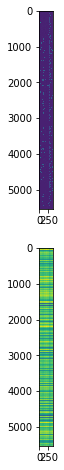

Itr 0, Obj 2697141.081205
Itr 1, Obj 2445921.131833
Itr 2, Obj 2294456.284305
Itr 3, Obj 2187584.666955
Itr 4, Obj 2105534.307314
Itr 5, Obj 2039077.949150
Itr 6, Obj 1983898.204914
Itr 7, Obj 1936754.807289
Itr 8, Obj 1895557.972240
Itr 9, Obj 1859302.442079
Itr 10, Obj 1827013.986595
Itr 11, Obj 1797996.838959
Itr 12, Obj 1771548.145632
Itr 13, Obj 1747736.345800
Itr 14, Obj 1725516.231365
Itr 15, Obj 1705204.605388
Itr 16, Obj 1686478.689424
Itr 17, Obj 1669011.578008
Itr 18, Obj 1652615.530151
Itr 19, Obj 1637223.881395
Itr 20, Obj 1622906.400071


In [ ]:
yeast_c_cutoff = NetREX(e_yeast_3, c_yeast_3, lmbda)
yeast_c_cutoff.NetREX_algorithm()